notes on memoire:

framework: flower

federated learning setting : Cross_silo

In [1]:
!pip install -q flwr[simulation]
!pip install tensorflow
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8

In [2]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(physical_devices, "GPU")

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flwr.common import Metrics
import keras
tf.keras.utils.set_random_seed(7)
tf.config.experimental.enable_op_determinism()


In [5]:
config = "NDLKDD FedYogi"

In [6]:
#importing dataseet
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
train_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/multi/KDDTrain_multi_combined.txt")
test_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/multi/KDDTest_multi_combined.txt")

Mounted at /content/drive


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X_test, y_true):
    # Step 2: Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Step 3: Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Step 4: Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Step 5: Calculate F1-score
    f1score = f1_score(y_true, y_pred, average='weighted')

    # Step 6: Calculate Recall
    recall = recall_score(y_true, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1score)

    # Generate the classification report
    classes = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
    print("\n\n",classification_report(y_test, y_pred))

    # Step 6: Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set labels and title

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Rotate the tick labels for better visibility
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Display the plot
    plt.show()

    num_classes = cm.shape[0]
    for class_idx in range(num_classes):
        row = cm[class_idx]

        tn = np.sum(np.delete(np.delete(cm, class_idx, axis=0), class_idx, axis=1))
        fp = np.sum(row) - cm[class_idx, class_idx]
        fn = np.sum(row) - cm[class_idx, class_idx]
        tp = cm[class_idx, class_idx]

        false_positive_rate = fp / (fp + tn)
        false_negative_rate = fn / (fn + tp)

        print("Class:", class_idx)
        print("False Positive Rate:", false_positive_rate)
        print("False Negative Rate:", false_negative_rate)
        print()

In [8]:
train_set = train_df
test_set = test_df
atk_labels = train_set['class'].unique()[train_set['class'].unique() != 0]
train_set
atk_labels

array([3, 1, 2, 4])

In [9]:
#Create a Keras model constructor
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten

def build_model():
  # Define your CNN-LSTM model
  cnn_lstm = Sequential()
  cnn_lstm.add(Dense(32, activation='relu', input_shape=(117, 1)))
  cnn_lstm.add(Conv1D(128, kernel_size=3, activation='relu'))
  cnn_lstm.add(MaxPooling1D(pool_size=2))
  cnn_lstm.add(LSTM(128, return_sequences=True))
  cnn_lstm.add(Dropout(0.3))
  cnn_lstm.add(Flatten())
  cnn_lstm.add(Dense(128, activation='relu'))
  cnn_lstm.add(Dense(5, activation='sigmoid'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  # Compile the cnn_lstm
  cnn_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return cnn_lstm

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model1(model, x_test, y_true):

    loss, _ = model.evaluate(x_test, y_true, verbose=0)
    # Step 2: Make predictions
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Step 3: Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Step 4: Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1.0)

    # Step 5: Calculate F1-score
    f1score = f1_score(y_true, y_pred, average='weighted')

    # Step 6: Calculate Recall
    recall = recall_score(y_true, y_pred, average='weighted')

    # Step 7: Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return cm, {
        "accuracy" : accuracy,
        "precision" : precision,
        "recall" : recall,
        "f1-score": f1score
    }, loss

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics for the given true labels and predicted labels.
    Returns a dictionary of metric values.
    """
    metrics = {}
    y_pred =np.argmax(y_pred, axis=1)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred,average='weighted')
    metrics['Precision'] = precision_score(y_true, y_pred,average='weighted')
    metrics['F1-score'] = f1_score(y_true, y_pred,average='weighted')

    return metrics

def write_metrics_to_dataframe(configuration_name, metrics_dict, df):
    """
    Write the classification metrics from the metrics dictionary to a DataFrame.
    The metrics are appended as a new row to the given DataFrame along with the configuration name.
    """
    metrics_dict['Configuration'] = configuration_name
    df = df.append(metrics_dict, ignore_index=True)
    return df

# Initializing the DataFrame
columns = ['Configuration', 'Accuracy', 'Recall', 'Precision', 'F1-score']
result_df = pd.DataFrame(columns=columns)


In [12]:
import math
from sklearn.utils import shuffle

nb_clients = 4


train_set = shuffle(train_set)

#calculating partition size for each client
partition_size = len(train_set)//nb_clients
print("partition size :", partition_size)
client_partitions = []

for i in range (nb_clients):
  #index range for the partition
  from_i, to_i = i*partition_size, (i+1)*partition_size
  #getting the partition
  partition = train_set[from_i: to_i]

  #not randomly removeing atk classes
  class_to_remove = i+1
  print("client: ", i)
  print("classes removed ", class_to_remove)
  partition = partition[partition['class'] != class_to_remove]
  print("classes: ", partition['class'].unique())
  print()
  y_part = partition['class']
  x_part = partition.drop('class', axis = 1)
  client_partitions.append((x_part, y_part, class_to_remove))



partition size : 25899
client:  0
classes removed  1
classes:  [0 3 2 4]

client:  1
classes removed  2
classes:  [1 0 3 4]

client:  2
classes removed  3
classes:  [0 2 1 4]

client:  3
classes removed  4
classes:  [1 0 2 3]



In [13]:
model = build_model()
part = client_partitions[0]
history = model.fit(part[0], part[1], batch_size = 64, epochs = 10)

Epoch 1/10
260/260 [==============================] - 16s 7ms/step - loss: 0.2173 - accuracy: 0.9243
Epoch 2/10
260/260 [==============================] - 2s 7ms/step - loss: 0.1032 - accuracy: 0.9610
Epoch 3/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0877 - accuracy: 0.9672
Epoch 4/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0802 - accuracy: 0.9688
Epoch 5/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0707 - accuracy: 0.9734
Epoch 6/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0657 - accuracy: 0.9756
Epoch 7/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0634 - accuracy: 0.9760
Epoch 8/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0594 - accuracy: 0.9764
Epoch 9/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0561 - accuracy: 0.9764
Epoch 10/10
260/260 [==============================] - 2s 7ms/step - loss: 0.0526 - accuracy: 0.979

In [14]:
y_test = test_set['class']
x_test = test_set.drop('class', axis = 1)
evaluate_model1(model, x_test, y_test)
#model.save('/content/drive/MyDrive/Colab Notebooks/h5 models/partition-model.h5')

696/696 [==============================] - 2s 3ms/step


(array([[11290,     0,    47,   125,     0],
        [ 1175,     0,  6819,    60,     0],
        [   63,     0,  2061,     0,     1],
        [   75,     0,     0,   493,     2],
        [   13,     0,     0,     7,    29]]),
 {'accuracy': 0.6232255166217431,
  'precision': 0.8650734463127728,
  'recall': 0.6232255166217431,
  'f1-score': 0.540177795591448},
 9.282808303833008)

In [15]:
len(client_partitions)

4

In [16]:
#Creating a Client Class
class FlwrClient(fl.client.NumPyClient):
    def __init__(self, cid, X, y):
        self.X_train = X
        self.y_train = y
        self.cid = cid

        self.model = build_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            verbose=0,  # suppress logging for clients
        )
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test, y_test)
        return loss, len(x_test), {"accuracy": float(accuracy)}

In [17]:
#create a client IDs list
client_ids_list = [f"client_{i}" for i in range(nb_clients)]

#create a dictionary {client_id: x_train_partition}
clientIds_wParts = dict(zip(client_ids_list, client_partitions))

#function for generating clients input is like "client_5"
def gen_client( client_id: str) -> fl.client.NumPyClient:
  return FlwrClient(
      client_id,
      clientIds_wParts[client_id][0],
      clientIds_wParts[client_id][1]
  )

In [18]:
from flwr.server.strategy import *

In [19]:
imported_items = dir()

# Print the imported items
print(imported_items)

['Conv1D', 'Dense', 'Dropout', 'FaultTolerantFedAvg', 'FedAdagrad', 'FedAdam', 'FedAvg', 'FedAvgAndroid', 'FedAvgM', 'FedMedian', 'FedOpt', 'FedProx', 'FedXgbNnAvg', 'FedYogi', 'Flatten', 'FlwrClient', 'In', 'LSTM', 'List', 'MaxPooling1D', 'Metrics', 'OrderedDict', 'Out', 'QFedAvg', 'Sequential', 'Strategy', 'Tuple', '_', '_14', '_15', '_8', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy_score', 'atk_labels', 'build_model', 'calculate_metrics', 'class_to_remove', 'classification_report', 'clientIds_wParts', 'client_ids_list', 'client_partitions', 'columns', 'config', 'confusion_matrix', 'drive', 'evaluate_model', 'evaluate_model1', 'exit', 'f1_score', 'fl', 'from_i', 'gen_client', 'get_ipython', 'history', 'i', 'keras', 

In [20]:
from typing import Optional, Dict
from flwr.common import Scalar, NDArrays, ndarrays_to_parameters

fl_weights = None
initial_params = ndarrays_to_parameters(build_model().get_weights())

def eval_round_model(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
  if server_round == 5: #if we are at the last round (10th)
    global fl_weights
    fl_weights = parameters

  #update the global model with latest weights
  model.set_weights(parameters)
  _, metrics, loss = evaluate_model1(model, x_test, y_test)
  return loss, metrics

strategy = fl.server.strategy.FedYogi(
    fraction_fit = 1.0,           # Sample ALL available clients for training
    min_fit_clients = 4,         # Never sample less than 7 clients for training
    min_available_clients = 4,   # Wait until all 7 clients are available
    evaluate_fn = eval_round_model,    # Evaluate the model after each round using this function
    on_fit_config_fn = lambda rnd: {  # Use this function to configure the training
        "epochs": 10,                # Train for 20 epochs
        "batch_size": 64,           # Use a batch size of 64
    },
    initial_parameters = initial_params,    # Initialize the model with these parameters
)


In [21]:
print(f"Number of clients: {nb_clients}")
clients = []
for key, value in clientIds_wParts.items():
  print(f"  {key}: \t X: {value[0].shape}, classes manquantes : {value[2]}")
  client = FlwrClient(cid = key, X = value[0], y = value[1])
  clients.append(client)


Number of clients: 4
  client_0: 	 X: (16628, 117), classes manquantes : 1
  client_1: 	 X: (23420, 117), classes manquantes : 2
  client_2: 	 X: (25245, 117), classes manquantes : 3
  client_3: 	 X: (25865, 117), classes manquantes : 4


In [22]:
hist = fl.simulation.start_simulation(
    client_fn= gen_client,
    clients_ids=client_ids_list,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=None,
)

INFO flwr 2023-06-25 07:34:08,701 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-06-25 07:34:11,010	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-25 07:34:12,013 | app.py:180 | Flower VCE: Ray initialized with resources: {'accelerator_type:A100': 1.0, 'memory': 53447545652.0, 'CPU': 12.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 26723772825.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'accelerator_type:A100': 1.0, 'memory': 53447545652.0, 'CPU': 12.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 26723772825.0}
INFO flwr 2023-06-25 07:34:12,015 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-25 07:34:12,016 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provide

696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 07:34:16,572 | server.py:91 | initial parameters (loss, other metrics): 1.6153745651245117, {'accuracy': 0.029874213836477988, 'precision': 0.5316927685061484, 'recall': 0.029874213836477988, 'f1-score': 0.019378919018970174}
INFO:flwr:initial parameters (loss, other metrics): 1.6153745651245117, {'accuracy': 0.029874213836477988, 'precision': 0.5316927685061484, 'recall': 0.029874213836477988, 'f1-score': 0.019378919018970174}
INFO flwr 2023-06-25 07:34:16,574 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-06-25 07:34:16,576 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 1: strategy sampled 4 clients (out of 4)
(pid=6092) 2023-06-25 07:34:18.241567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_fit pid=6092) 2023-06-25 07:34:19.758327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DE

696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 07:39:52,428 | server.py:119 | fit progress: (1, 1.3180731534957886, {'accuracy': 0.5149146451033243, 'precision': 0.7502224466385581, 'recall': 0.5149146451033243, 'f1-score': 0.35003568365899435}, 335.85247893500014)
INFO:flwr:fit progress: (1, 1.3180731534957886, {'accuracy': 0.5149146451033243, 'precision': 0.7502224466385581, 'recall': 0.5149146451033243, 'f1-score': 0.35003568365899435}, 335.85247893500014)
DEBUG flwr 2023-06-25 07:39:52,430 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)


463/696 [==================>...........] - ETA: 4s - loss: 1.3194 - accuracy: 0.5118 [repeated 8x across cluster]


DEBUG flwr 2023-06-25 07:40:09,253 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-25 07:40:09,255 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-25 07:40:09,257 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


696/696 [==============================] - 15s 21ms/step - loss: 1.3181 - accuracy: 0.5149


DEBUG flwr 2023-06-25 07:45:40,028 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures


696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 07:45:44,724 | server.py:119 | fit progress: (2, 0.977473795413971, {'accuracy': 0.5530098831985625, 'precision': 0.7417143708752602, 'recall': 0.5530098831985625, 'f1-score': 0.43256682163141874}, 688.148127314)
INFO:flwr:fit progress: (2, 0.977473795413971, {'accuracy': 0.5530098831985625, 'precision': 0.7417143708752602, 'recall': 0.5530098831985625, 'f1-score': 0.43256682163141874}, 688.148127314)
DEBUG flwr 2023-06-25 07:45:44,726 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)


463/696 [==================>...........] - ETA: 4s - loss: 0.9811 - accuracy: 0.5505 [repeated 9x across cluster]


DEBUG flwr 2023-06-25 07:46:01,401 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-25 07:46:01,403 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)


487/696 [===================>..........] - ETA: 4s - loss: 0.9786 - accuracy: 0.5512 [repeated 7x across cluster]


DEBUG flwr 2023-06-25 07:51:27,209 | server.py:232 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures


696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 07:51:31,916 | server.py:119 | fit progress: (3, 0.6772618889808655, {'accuracy': 0.7018418688230009, 'precision': 0.8156488440045663, 'recall': 0.7018418688230009, 'f1-score': 0.6818645690372527}, 1035.340602402)
INFO:flwr:fit progress: (3, 0.6772618889808655, {'accuracy': 0.7018418688230009, 'precision': 0.8156488440045663, 'recall': 0.7018418688230009, 'f1-score': 0.6818645690372527}, 1035.340602402)
DEBUG flwr 2023-06-25 07:51:31,919 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 4 clients (out of 4)


460/696 [==================>...........] - ETA: 4s - loss: 0.6814 - accuracy: 0.6989 [repeated 10x across cluster]


DEBUG flwr 2023-06-25 07:51:48,889 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-06-25 07:51:48,892 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)


696/696 [==============================] - 16s 21ms/step - loss: 0.6773 - accuracy: 0.7018


DEBUG flwr 2023-06-25 07:57:18,297 | server.py:232 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures


696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 07:57:22,889 | server.py:119 | fit progress: (4, 0.2594122886657715, {'accuracy': 0.8999101527403415, 'precision': 0.910372184553171, 'recall': 0.8999101527403415, 'f1-score': 0.8878061060271432}, 1386.313727021)
INFO:flwr:fit progress: (4, 0.2594122886657715, {'accuracy': 0.8999101527403415, 'precision': 0.910372184553171, 'recall': 0.8999101527403415, 'f1-score': 0.8878061060271432}, 1386.313727021)
DEBUG flwr 2023-06-25 07:57:22,891 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 4 clients (out of 4)


463/696 [==================>...........] - ETA: 4s - loss: 0.2627 - accuracy: 0.8984 [repeated 11x across cluster]


DEBUG flwr 2023-06-25 07:57:39,642 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-06-25 07:57:39,645 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)


487/696 [===================>..........] - ETA: 4s - loss: 0.2613 - accuracy: 0.8985 [repeated 8x across cluster]


DEBUG flwr 2023-06-25 08:03:09,139 | server.py:232 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures


696/696 [==============================] - 2s 3ms/step


INFO flwr 2023-06-25 08:03:13,697 | server.py:119 | fit progress: (5, 0.1546192765235901, {'accuracy': 0.945193171608266, 'precision': 0.9491117599400763, 'recall': 0.945193171608266, 'f1-score': 0.9396887118462671}, 1737.1216047840003)
INFO:flwr:fit progress: (5, 0.1546192765235901, {'accuracy': 0.945193171608266, 'precision': 0.9491117599400763, 'recall': 0.945193171608266, 'f1-score': 0.9396887118462671}, 1737.1216047840003)
DEBUG flwr 2023-06-25 08:03:13,699 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 4 clients (out of 4)


463/696 [==================>...........] - ETA: 4s - loss: 0.1575 - accuracy: 0.9443 [repeated 12x across cluster]


DEBUG flwr 2023-06-25 08:03:30,406 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 4 results and 0 failures
INFO flwr 2023-06-25 08:03:30,409 | server.py:147 | FL finished in 1753.8332904570002
INFO:flwr:FL finished in 1753.8332904570002
INFO flwr 2023-06-25 08:03:30,411 | app.py:218 | app_fit: losses_distributed [(1, 1.3180557489395142), (2, 0.9774420857429504), (3, 0.6772887110710144), (4, 0.2594223916530609), (5, 0.15462610125541687)]
INFO:flwr:app_fit: losses_distributed [(1, 1.3180557489395142), (2, 0.9774420857429504), (3, 0.6772887110710144), (4, 0.2594223916530609), (5, 0.15462610125541687)]
INFO flwr 2023-06-25 08:03:30,413 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-25 08:03:30,415 | app.py:220 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2023-06-25 08:03:30,416 | app.py:221 | app_fit: losses_centralized [(0,

696/696 [==============================] - 15s 21ms/step - loss: 0.1546 - accuracy: 0.9452


In [23]:
modelfl = build_model()
modelfl.set_weights(fl_weights)

modelfl.save('/content/drive/MyDrive/Colab Notebooks/h5 models/Federated-model.h5')

696/696 [==============================] - 15s 21ms/step - loss: 0.1546 - accuracy: 0.9452


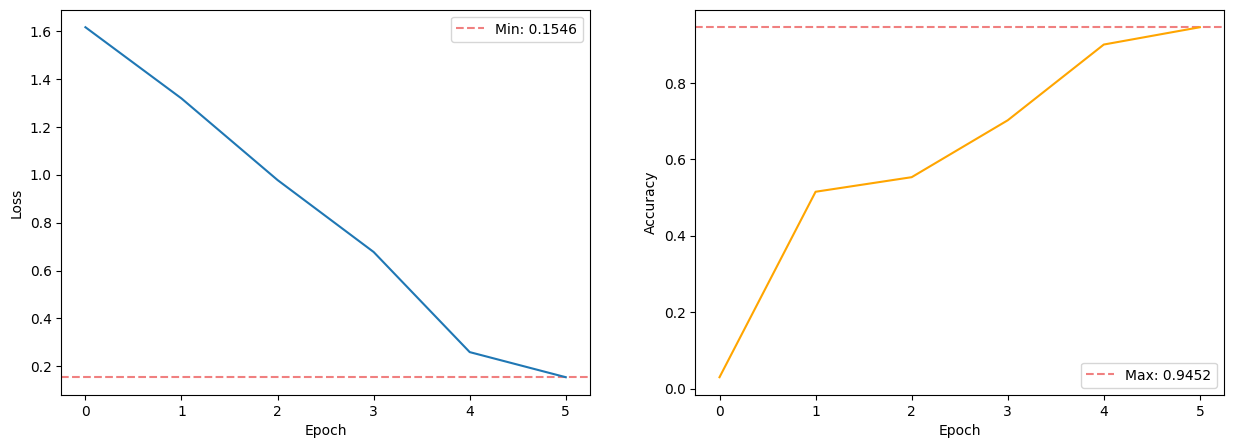

In [24]:
loss = [i[1] for i in hist.losses_centralized]
acc = [i[1] for i in hist.metrics_centralized["accuracy"]]

# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(loss)
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(acc)
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(acc, color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

In [25]:
evaluate_model1(modelfl, x_test, y_test)

696/696 [==============================] - 2s 3ms/step


(array([[11415,     3,    44,     0,     0],
        [  382,  7636,    36,     0,     0],
        [  295,     7,  1823,     0,     0],
        [  426,     1,     1,   142,     0],
        [   25,     0,     0,     0,    24]]),
 {'accuracy': 0.945193171608266,
  'precision': 0.9491117599400763,
  'recall': 0.945193171608266,
  'f1-score': 0.9396887118462671},
 0.1546192765235901)

In [26]:
result_df = write_metrics_to_dataframe("model_fl "+config, calculate_metrics(y_test, modelfl.predict(x_test)), result_df)
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/FL"+config+".txt", index = False)

696/696 [==============================] - 2s 3ms/step


<ipython-input-11-630fbd364ecf>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(metrics_dict, ignore_index=True)
